In [261]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import simpledorff
import utils
from eval_functions import *
import experiments
from experiment_manager import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Japanese-English translations data

In [262]:
translations_mini_exp = T2TranslationExperiment()

### Let's subsample the data for simplicity

In [263]:
SEED = 9
np.random.seed(SEED)

# subsample sentences

num_sentences_to_sample = 6
sample_sentences = np.random.choice(translations_mini_exp.golddf.sentence, num_sentences_to_sample, replace=False)

sampled_annodf = translations_mini_exp.annodf.set_index("sentence").loc[sample_sentences].reset_index()
translations_mini_exp.annodf = sampled_annodf

# subsample workers

translations_mini_exp.annodf = translations_mini_exp.prune_data(0.5)

In [264]:
translations_mini_exp.annodf

,sentence,worker,workeranswer
0,33,worker16,She was very kind to show the town.
1,33,worker0,She kindly showed me around the town.
2,33,worker16,She was very kind to show the town.
3,33,worker16,She was very kind for me to show the town.
4,33,worker93,She take me on the tour in town kindly.
5,358,worker97,This is the book I was looking for.
6,358,worker96,This is the very book that I was looking for.
7,358,worker36,This is exactly the book I was looking for.
8,358,worker41,This is the book just I look for.
9,358,worker101,This is the book I was looking for


### Six sentences, five workers each

In [443]:
translations_mini_exp.annodf.groupby("sentence")["worker"].count()

sentence
33     5
358    5
378    5
415    5
646    5
728    5
Name: worker, dtype: int64

### Let's get label distance matrices and plot the distances

In [265]:
def get_distance_matrix(all_labels, dist_fn):
    label_distances = [[dist_fn(label_a, label_b) if i < j else np.nan
                        for i, label_a in enumerate(all_labels)]
                        for j, label_b in enumerate(all_labels)]
    return np.array(label_distances)

def plot_matrix(distance_matrix, labels=None, figsize=8, title=None, show_grid=True):
    fix, ax = plt.subplots(figsize=(figsize, figsize))
    if labels is not None:
        for i, label in enumerate(all_labels):
            plt.annotate(label, (i, 0.15 + i), color="k")
    plt.imshow(distance_matrix, vmin=-0.1, vmax=1.5, cmap="plasma")
    ax = plt.gca();
    if show_grid:
        minor_grids = np.arange(-.5, distance_matrix.shape[0], 1)
        ax.set_xticks(minor_grids, minor=True)
        ax.set_yticks(minor_grids, minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if title is not None:
        plt.title(title)
    plt.show()


In [266]:
translations_mini_exp.annodf = translations_mini_exp.annodf.sort_values("sentence")
all_labels = translations_mini_exp.annodf["workeranswer"]

### Using BLEU for evaluation, 1 - BLEU as distance function

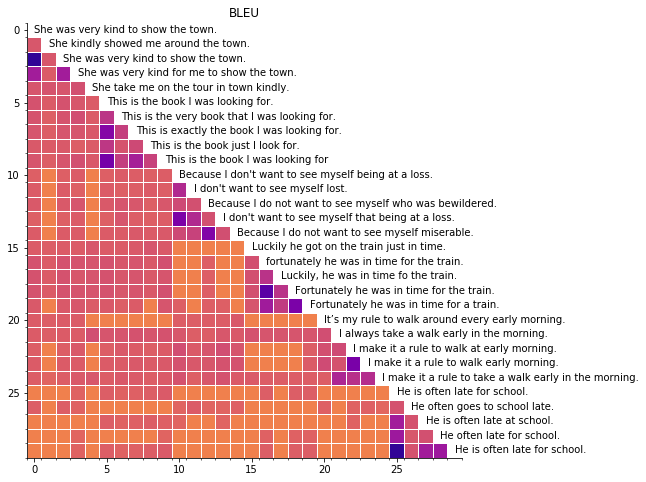

In [267]:
BLEU_distance_fn = lambda x,y: 1 - bleu2way(x,y)
BLEU_distance_matrix = get_distance_matrix(all_labels, BLEU_distance_fn)
plot_matrix(BLEU_distance_matrix, labels=all_labels, title="BLEU")

Note the contrast between same-item (dark right triangles on the diagonal) and different-item (light everywhere else)

### Using GLEU for evaluation, 1 - GLEU as distance function

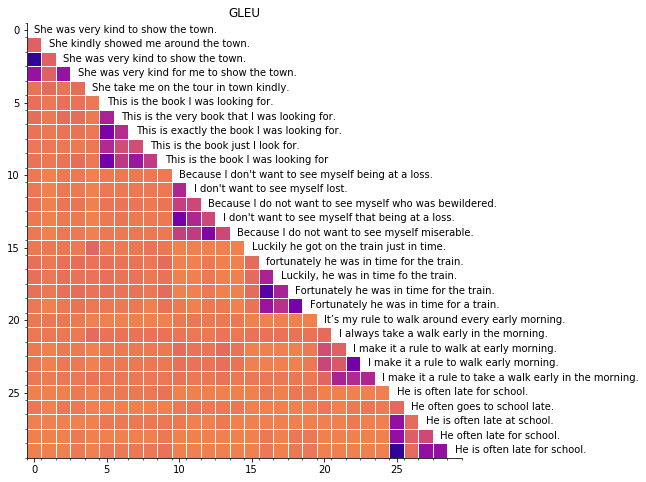

In [268]:
GLEU_distance_fn = lambda x,y: 1 - gleu2way(x,y)
GLEU_distance_matrix = get_distance_matrix(all_labels, GLEU_distance_fn)
plot_matrix(GLEU_distance_matrix, labels=all_labels, title="GLEU")

#### Note the contrast between same-item and different-item distances is even starker for GLEU than for BLEU

Inter-annotator agreement measures work by comparing _same-item_ "observed" distances against _different-item_ "expected" distances

In [269]:
items = translations_mini_exp.annodf["sentence"]
same_item = np.array([[np.nan if item_a != item_b else 1 for item_a in items] for item_b in items])
different_item = np.array([[np.nan if item_a == item_b else 1 for item_a in items] for item_b in items])


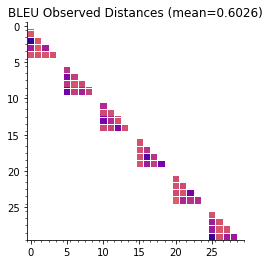

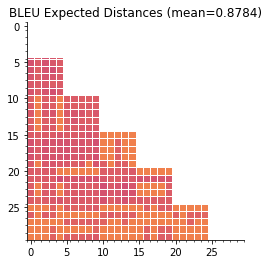

In [270]:
BLEU_mean_observed_distance = np.nanmean(same_item * BLEU_distance_matrix)
BLEU_mean_expected_distance = np.nanmean(different_item * BLEU_distance_matrix)

plot_matrix(same_item * BLEU_distance_matrix, figsize=4,
            title=F"BLEU Observed Distances (mean={np.round(BLEU_mean_observed_distance, 4)})")
plot_matrix(different_item * BLEU_distance_matrix, figsize=4,
            title=F"BLEU Expected Distances (mean={np.round(BLEU_mean_expected_distance, 4)})")

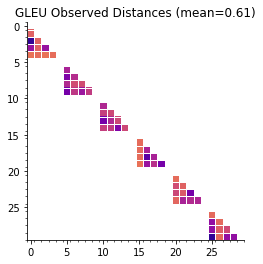

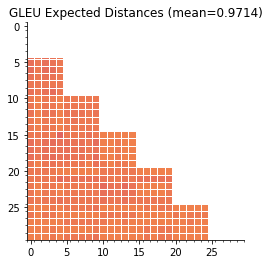

In [271]:
GLEU_mean_observed_distance = np.nanmean(same_item * GLEU_distance_matrix)
GLEU_mean_expected_distance = np.nanmean(different_item * GLEU_distance_matrix)

plot_matrix(same_item * GLEU_distance_matrix, figsize=4,
            title=F"GLEU Observed Distances (mean={np.round(GLEU_mean_observed_distance, 4)})")
plot_matrix(different_item * GLEU_distance_matrix, figsize=4,
            title=F"GLEU Expected Distances (mean={np.round(GLEU_mean_expected_distance, 4)})")

Krippendorff's $\alpha$ compares mean observed distances D<sub>o</sub> to mean expected distances D<sub>e</sub>

$\alpha = 1 - \frac{D_o}{D_e}$

In [282]:
def kripp_alpha(distance_matrix, items, agg_fn=np.nanmean):
    same_item = np.array([[np.nan if item_a != item_b else 1 for item_a in items] for item_b in items])
    different_item = np.array([[np.nan if item_a == item_b else 1 for item_a in items] for item_b in items])
    mean_observed_distance = agg_fn(same_item * distance_matrix)
    mean_expected_distance = agg_fn(different_item * distance_matrix)
    return 1 - mean_observed_distance / mean_expected_distance

In [283]:
kripp_alpha(BLEU_distance_matrix, items)

0.31405235260704045

In [284]:
kripp_alpha(GLEU_distance_matrix, items)

0.3720402492242415

Somehow the difference in scores between BLEU and GLEU is not as stark as the contrast in the visual heatmaps

What if instead of looking at _mean_ distance per group, we looked at the _median_?

In [451]:
kripp_alpha(BLEU_distance_matrix, items, np.nanmedian)

0.18030170056487838

In [452]:
kripp_alpha(GLEU_distance_matrix, items, np.nanmedian)

0.3474747474747475

What if instead we looked at top q _quantile_?

In [449]:
kripp_alpha(BLEU_distance_matrix, items, lambda x: np.nanquantile(x, 0.1))

0.6177129777873627

In [450]:
kripp_alpha(GLEU_distance_matrix, items, lambda x: np.nanquantile(x, 0.1))

0.7118131868131867

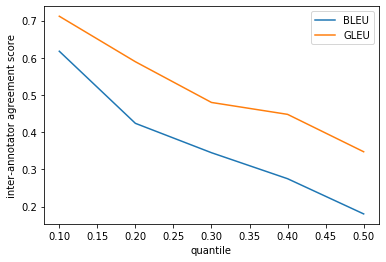

In [446]:
qs = [0.1, 0.2, 0.3, 0.4, 0.5]
bleu_iaa_qs = [kripp_alpha(BLEU_distance_matrix, items, lambda x: np.nanquantile(x, q)) for q in qs]
gleu_iaa_qs = [kripp_alpha(GLEU_distance_matrix, items, lambda x: np.nanquantile(x, q)) for q in qs]
plt.plot(qs, bleu_iaa_qs)
plt.plot(qs, gleu_iaa_qs)
plt.xlabel("quantile")
plt.ylabel("inter-annotator agreement score")
plt.legend(["BLEU", "GLEU"])
plt.show()

But this quantile is over the whole dataset. We should probably break it down by item before applying quantile.

Otherwise high agreement in a small number of items can skew the results. 

In [290]:
def agg_by_item(distance_matrix, items, agg_fn):
    result = distance_matrix.copy()
    item_pairs = np.array([[F"{item_a}-{item_b}" for item_a in items] for item_b in items])
    notnan = np.logical_not(np.isnan(distance_matrix))
    for ip in np.unique(item_pairs):
        indices = np.where(np.logical_and(item_pairs == ip, notnan))
        masked_dists = distance_matrix[indices]
        result[indices] = agg_fn(masked_dists)
    return result


## Aggregate quantile distance per item

/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1367: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


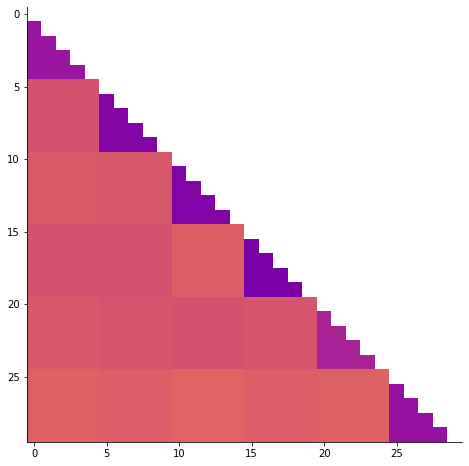

In [461]:
BLEU_item_quantile_distance_matrix = agg_by_item(BLEU_distance_matrix, items, lambda x: np.nanquantile(x, 0.1))
plot_matrix(BLEU_item_quantile_distance_matrix, show_grid=False)

/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1367: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


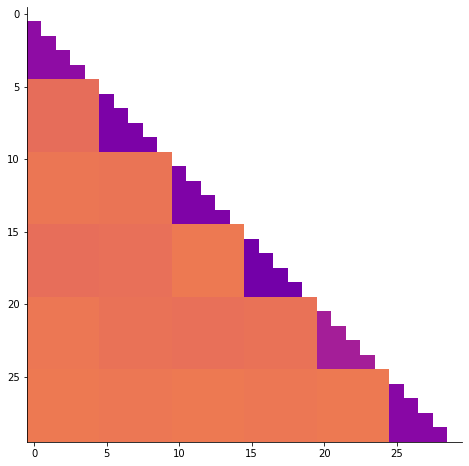

In [462]:
GLEU_item_quantile_distance_matrix = agg_by_item(GLEU_distance_matrix, items, lambda x: np.nanquantile(x, 0.1))
plot_matrix(GLEU_item_quantile_distance_matrix, show_grid=False)

In [465]:
kripp_alpha(BLEU_item_quantile_distance_matrix, items)

0.5381314036281046

In [466]:
kripp_alpha(GLEU_item_quantile_distance_matrix, items)

0.6371707228869914

## Let's try to understand Krippendorff $\alpha$ a little better

In [328]:
def obs_vs_exp_distances(distance_matrix, items):
    same_item = np.array([[np.nan if item_a != item_b else 1 for item_a in items] for item_b in items])
    different_item = np.array([[np.nan if item_a == item_b else 1 for item_a in items] for item_b in items])
    observed_distances = same_item * distance_matrix
    expected_distances = different_item * distance_matrix
    observed_distances = observed_distances[~np.isnan(observed_distances)]
    expected_distances = expected_distances[~np.isnan(expected_distances)]
    return observed_distances, expected_distances

#### Break the scores down into observed distances and expected distances

In [370]:
BLEU_obs_dists, BLEU_exp_dists = obs_vs_exp_distances(BLEU_distance_matrix, items)
GLEU_obs_dists, GLEU_exp_dists = obs_vs_exp_distances(GLEU_distance_matrix, items)

In [374]:
def plot_distance_distributions(obs_dists, exp_dists, title=None):
    fig, ax = plt.subplots()
    DoH = ax.hist(obs_dists, color="b", alpha=0.5)
    DoM, = ax.plot([obs_dists.mean(), obs_dists.mean()], [0, ax.get_ylim()[1]], "b:")
    ax2 = ax.twinx()
    DeH = ax2.hist(exp_dists, color="r", alpha=0.5)
    DeM, = ax2.plot([exp_dists.mean(), exp_dists.mean()], [0, ax2.get_ylim()[1]], "r:")
    plt.legend([DoM, DeM], ["observed distance", "expected distance"])
    if title is not None:
        plt.title(title)
    plt.show()

#### Plot the histograms of observed distances and expected distances

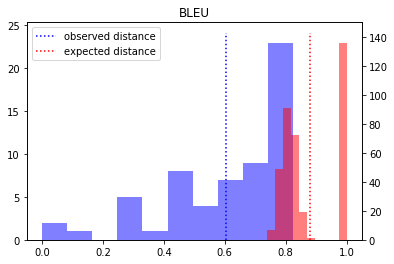

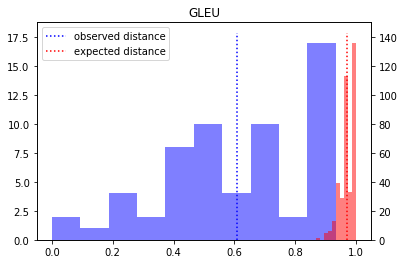

In [375]:
plot_distance_distributions(BLEU_obs_dists, BLEU_exp_dists, title="BLEU")
plot_distance_distributions(GLEU_obs_dists, GLEU_exp_dists, title="GLEU")

Note that using the means (dotted lines) as Krippendorff's $\alpha$ does throws away a lot of interesting information. The means are a bit farther apart between BLEU and GLEU, but as we noted it is not a particularly stark difference. More importantly, it is not an **interpretable** difference. What the distributions tell us is more interpretable: That there is substantial **overlap** between observed and expected distances in the case of BLEU, and not so much in the case of GLEU.

Maybe instead of just comparing their point _means_, we should compare their distribution _overlaps_

How exactly? T-test, KL-divergence, Kolmogorov-Smirnov?

In [392]:
import scipy.stats as stats

#### Kolmogorov-Smirnov non-parametric test of difference between two distributions

In [393]:
stats.ks_2samp(BLEU_obs_dists, BLEU_exp_dists, alternative="greater")

Ks_2sampResult(statistic=0.7986666666666666, pvalue=6.315614250981385e-35)

In [394]:
stats.ks_2samp(GLEU_obs_dists, GLEU_exp_dists, alternative="greater")

Ks_2sampResult(statistic=0.918, pvalue=2.445443296632906e-51)

The problem with p-statistics is the interpretation. We already expect these distributions are different enough that the difference is "statistically significant", we need a more meaningful and interpretable measure for comparison.

For example, something like "how often are my observed distances indistinguishable from expected distances?"

We can try using a Kernel Density Estimator (KDE) to get a non-parametric cumulative distribution (CDF) for the _expected distance_ $D_e$.

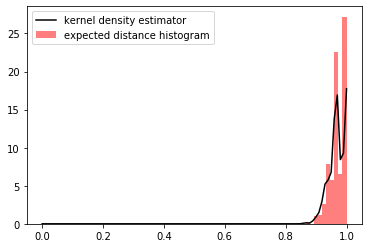

In [415]:
GLEU_kde = stats.gaussian_kde(GLEU_exp_dists)
x = np.linspace(0, 1, 100)
GLEU_DeKDE = GLEU_kde.evaluate(x)
plt.plot(x, GLEU_DeKDE, "k")
plt.hist(GLEU_exp_dists, density=True, color="r", alpha=0.5)
plt.legend(["kernel density estimator", "expected distance histogram"])
plt.show()

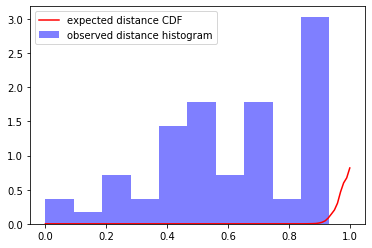

In [427]:
cdf = [GLEU_kde.integrate_box_1d(0, d) for d in x]
plt.plot(x, cdf, color="r")
plt.hist(GLEU_obs_dists, density=True, color="b", alpha=0.5)
plt.legend(["expected distance CDF", "observed distance histogram"])
plt.show()

Now for each of the _observed distances_ d we can use this CDF to estimate the probability of at-least-that-small a distance coming from the expected distance distribution $P(D_e)$.

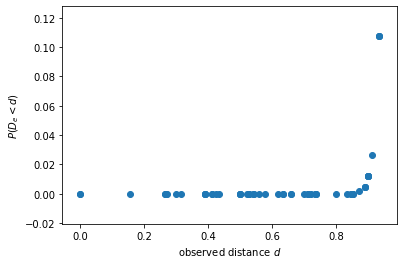

In [434]:
GLEU_pDeLtDo = cdf = [GLEU_kde.integrate_box_1d(0, d) for d in GLEU_obs_dists]
plt.scatter(GLEU_obs_dists, GLEU_pDeLtDo)
plt.xlabel("observed distance $d$")
plt.ylabel("$P(D_e<d)$")
plt.show()

#### Based on the above, we can say 
* "there is only one observed distance in the whole dataset that could have been expected at random with more than 5% probability."

In other words:

* "one translation is so off-consensus it looks like it could have been for a different sentence."

We should still try to do this on a per-item basis. It would be important to know whether the "off-consensus translations" occur uniformly across items versus being concentrated within a few items.

One reason inter-annotator agreement measures are useful is that aggregation methods such as MV don't tell you _how good_ your aggregate labels are. Probabilistic methods can tell you confidence, but the process illustrated above seems relatively transparent.

## Now let's look at the full dataset

In [161]:
translations_full_exp = T2TranslationExperiment()

In [162]:
translations_full_exp.annodf = translations_full_exp.annodf.sort_values("sentence")
all_labels = translations_full_exp.annodf["workeranswer"]

In [163]:
GLEU_distance_matrix = get_distance_matrix(all_labels, GLEU_distance_fn)

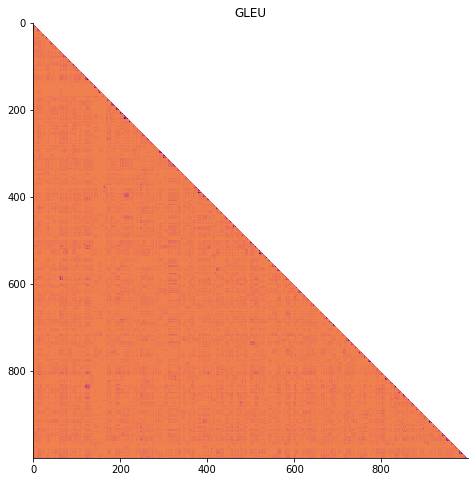

In [164]:
plot_matrix(GLEU_distance_matrix, labels=None, title="GLEU", show_grid=False)

Hard to see, way more computation calculating distance function across off-diagonal

Krippendorff's $\alpha$ using _simpledorff_ library

In [81]:
def calc_krippendorf_alpha(expmnt, dist_fn=None):
    if dist_fn is None:
        dist_fn = expmnt.distance_fn
    return simpledorff.calculate_krippendorffs_alpha_for_df(expmnt.annodf,
                                                         experiment_col=expmnt.item_colname,
                                                         annotator_col=expmnt.uid_colname,
                                                         class_col=expmnt.label_colname,
                                                         metric_fn=dist_fn)